<a href="https://colab.research.google.com/github/dinesh110598/Spin_glass_NN/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of different types of spin glass phases

Spin glass phases typically occur in frustrated spin systems where minimum energy cannot be attained in all lattice sites. They can occur in two possible situations:
1. Disorder in values of coupling constants. Eg: Edwards Anderson (EA) spin glass phase
2. Geometric constraints on neighbouring spin values. Eg: Antiferromagnetic triangular Ising glass phase

As it turns out, distinguishing these two kinds of spin glass phases is non-trivial and not possible by calculating quantities like magnetization, susceptibility, two point correlations. Our aim will be to feed simulated thermal ensembles of EA spin glass and triangular antiferromagnetic spin glass labelled categorically, to a convolutional neural network and see whether it accurately learns the inherent difference in their statistics 

## Phase change in 2D Triangular Antiferromagnetic Ising Model

In [ ]:
#importing necessary libraries
import numpy as np
import tensorflow as tf
from numba import cuda,jit
from tensorflow import keras
import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


We'll import the pre-written CUDA simulator class that will provide MCMC samples of 2D Triangular Antiferromagnetic Ising Model of given lattice length and ensemble size...  

In [ ]:
import os
import sys
sys.path.append(os.path.abspath(
"/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/Ising_simulation"))
import TriAFM_2d #Stands for Triangular antiferromagnetic 2d

Below line initializes the class object that has various functionalities to simulate and generate different kinds of data related to the model...

In [ ]:
simulator = TriAFM_2d.GPUSimulator (60,40)

Let's run a simulation to output magnetization vs temperature plot:

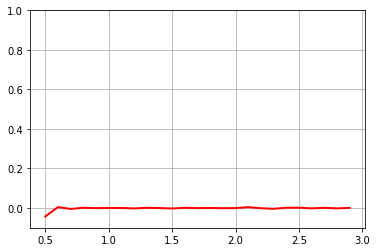

In [ ]:
simulator.mag_data (0.5,3.0,0.1)

It's clear that average magnetization is totally incapable of determining any phase transition in the system here. Let's now have a neural network that detects phase transition in the antiferromagnetic triangular Ising model, if any...

In [ ]:
#Very long runtime expected...
train_len = 5000
train_lattice, train_label = simulator.generate_train_data (train_len)

I'll save the generated dataset so that the simulation above can be skipped

In [ ]:
train_path = '/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/Training Data'
np.save (train_path+'/TrAFM5k_60_40_lattice.npy',train_lattice)
np.save (train_path+'/TrAFM5k_60_40_label.npy',train_label)

Here, we load the simulated data directly:

In [ ]:
train_path = '/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/Training Data'
train_len = 5000
train_lattice = np.load (train_path+'/TrAFM5k_60_40_lattice.npy')
train_label = np.load (train_path+'/TrAFM5k_60_40_label.npy')

In [ ]:
#train_dataset = tf.data.Dataset.from_tensor_slices((train_lattice, train_label))

#writer = tf.data.experimental.TFRecordWriter ('TrAFM5k_60_40.tfrecord')
#writer.write ()

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

Splitting validation sets:

In [ ]:
val_lattice = train_lattice [int(0.8*train_len):]
val_label = train_label [int(0.8*train_len):]
train_lattice = train_lattice [:int(0.8*train_len)]
train_label = train_label [:int(0.8*train_len)]

In [ ]:
shape = train_lattice.shape [1:3]
ensemble_size = (train_lattice.shape [3],)

We'll define a typical convnet architecture to train with our data:

In [ ]:
brain = keras. Sequential([
    keras.layers.Conv2D(32, (3,3), input_shape= shape+ensemble_size),
    keras.layers.MaxPool2D (),
    keras.layers.Conv2D(32,(3,3)),
    keras.layers.MaxPool2D (),
    keras.layers.Conv2D(32,(3,3)),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization (),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(2, activation='softmax')
])

brain.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = brain.fit (train_lattice, train_label, batch_size=4, epochs=2,
                  validation_data= (val_lattice,val_label))

Epoch 1/2
1000/1000 [==============================] - 4s 4ms/step - loss: 0.1123 - accuracy: 0.9390 - val_loss: 0.0381 - val_accuracy: 0.9990
Epoch 2/2
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1170 - accuracy: 0.9362 - val_loss: 8.5351e-04 - val_accuracy: 1.0000


In [ ]:
test_len = 500
test_lattice, test_label = simulator.generate_train_data (test_len)

In [ ]:
test_lattice.shape

(500, 60, 60, 40)

In [ ]:
brain.evaluate (test_lattice, test_label,verbose=1)

16/16 [==============================] - 0s 13ms/step - loss: 4.5039e-05 - accuracy: 1.0000


[4.503871969063766e-05, 1.0]

Let's save the neural network model:

In [ ]:
nn_path = '/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/'
brain.save(nn_path+'TrAFM_60_40.h5')

Load the neural network directly here:

In [ ]:
nn_path = '/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/NN Models/'
brain = keras.models.load_model (nn_path+'TrAFM_60_40.h5')

Let's plot the temperature vs NN Output graph:

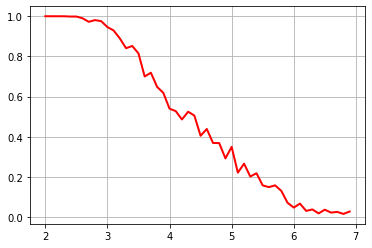

In [ ]:
simulator.neural_data (2.0,7.0,0.1,brain)

From the above graph, we see there's definitely some property of the ensemble that varies with temperature. However, it isn't clear whether it indicates a phase transition in some order...

## Phase change in 2D Edwards-Anderson (EA) square Ising Model

In [ ]:
#importing necessary libraries
import numpy as np
import tensorflow as tf
from numba import cuda,jit
from tensorflow import keras
import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


We'll import the pre-written CUDA simulator class that will provide MCMC samples of 2D Square Edward-Anderson Ising Model of given lattice length and ensemble size...  

In [ ]:
import os
import sys
sys.path.append(os.path.abspath(
"/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/Ising_simulation"))
import SqEA_2d #Stands for Triangular antiferromagnetic 2d

Below line initializes the class object that has various functionalities to simulate and generate different kinds of data related to the model...

In [ ]:
simulator = SqEA_2d.GPUsimulator (60,40)

Let's generate the magnetisation vs temperature plot using the above object:

In [ ]:
simulator.equilib (0.5)

/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/Ising_simulation/SqEA_2d.py:129: RuntimeWarning: overflow encountered in exp
  if np.random.uniform() < np.exp(arg):


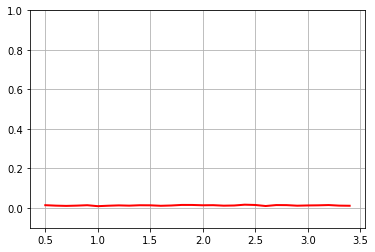

In [ ]:
simulator.mag_data (0.5,3.5,0.1)

Once again, it's clear that average magnetization is totally incapable of determining any phase transition in the system here. Let's now have a neural network that detects phase transition in the EA square Ising model, if any...

Note: If already saved data in drive, load the data by running the cell below [here](#load_data) and proceed

In [ ]:
#Very long runtime expected...
train_len = 5000
train_lattice, train_label = simulator.generate_train_data (train_len)

/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/Ising_simulation/SqEA_2d.py:129: RuntimeWarning: overflow encountered in exp
  if np.random.uniform() < np.exp(arg):


KeyboardInterrupt: ignored

We'll save the data to drive so that the above step could be skipped:

In [ ]:
train_path = '/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/Training Data'
np.save (train_path+'/SqEA5k_60_40_lattice.npy',train_lattice)
np.save (train_path+'/SqEA5k_60_40_label.npy',train_label)

<a id='load_data'></a>
Loading the pre-saved training data from here:

In [ ]:
train_path = '/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/Training Data'
train_len = 5000
train_lattice = np.load (train_path+'/SqEA5k_60_40_lattice.npy')
train_label = np.load (train_path+'/SqEA5k_60_40_label.npy')